# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [28]:
import numpy as np
import random
import math
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [29]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'train.p'
validation_file= 'valid.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [30]:
len(y_train)

34799

In [31]:
len(y_valid)

4410

In [32]:
len(y_test)

12630

In [33]:
#fraction of test data to all data
len(y_test)/(len(y_train)+len(y_valid)+len(y_test))

0.24363895908485889

In [34]:
#fraction of validation data to train data + validation data
len(y_valid)/(len(y_train)+len(y_valid))

0.11247417684715244

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

## Import Human Readable Labels
Load into array signnames

In [35]:
import csv
with open('signnames.csv') as d:
    signnames = [r[1] for r in list(csv.reader(d))[1:]]

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [36]:
train['features'].shape

(34799, 32, 32, 3)

In [37]:
import numpy as np
len(np.unique(train['labels']))

43

In [38]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = train['features'].shape[0]

# TODO: Number of validation examples
n_validation = valid['features'].shape[0]

# TODO: Number of testing examples.
n_test = test['features'].shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = (train['features'].shape[1],train['features'].shape[2])

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(train['labels']))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43



### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

In [39]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.

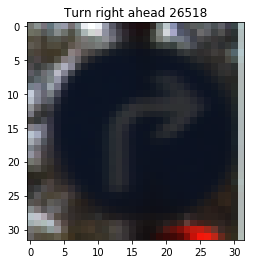

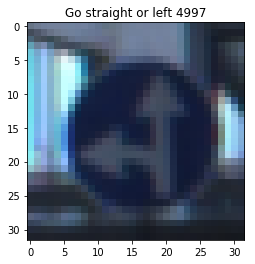

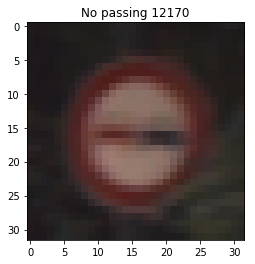

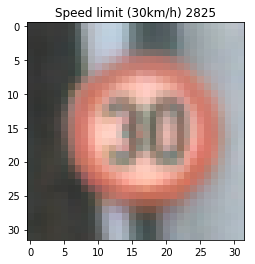

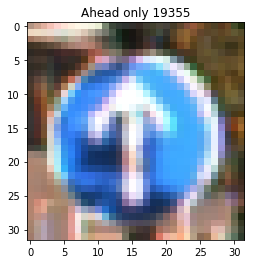

In [40]:
for i in range(5):
    index = random.randint(0,len(X_train))
    img = X_train[index]
    lab = y_train[index]
    plt.title(signnames[lab] + " " + str(index))
    plt.imshow(img)
    plt.show()

## Analyze the label distribution within each dataset

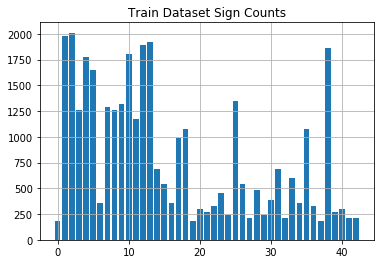

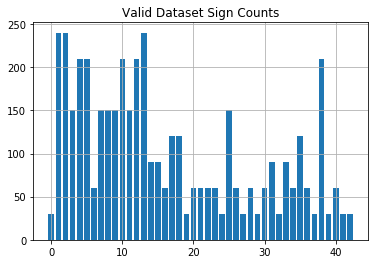

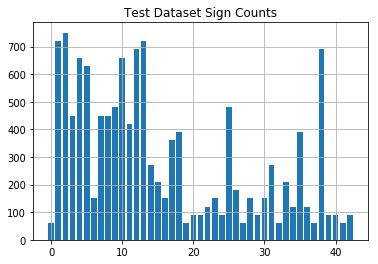

In [41]:
unique_train, counts_train = np.unique(y_train, return_counts=True)
plt.bar(unique_train, counts_train)
plt.grid()
plt.title("Train Dataset Sign Counts")
plt.show()

unique_valid, counts_valid = np.unique(y_valid, return_counts=True)
plt.bar(unique_valid, counts_valid)
plt.grid()
plt.title("Valid Dataset Sign Counts")
plt.show()

unique_test, counts_test = np.unique(y_test, return_counts=True)
plt.bar(unique_test, counts_test)
plt.grid()
plt.title("Test Dataset Sign Counts")
plt.show()

## Generate additional data
Many of the labels are under-represented, so we generate additional data here. Here we try to ensure that each class has at least 2000 samples.  For each under-represented class, we generate additional images by randomly selecting an image from the class and apply a random scale and rotation on the image.

In [42]:
#Make original train and valid datasets available with other variables
X_train_orig, y_train_orig = train['features'], train['labels']
X_valid_orig, y_valid_orig = valid['features'], valid['labels']
X_test_orig, y_test_orig = test['features'], test['labels']

#Concatenate original valid and train datasets so we don't lose good labeled data.  We'll recreate a new validation
#split given generated data.
X_train = np.append(X_train,X_valid,axis=0)
y_train = np.append(y_train,y_valid,axis=0)

In [43]:
#generates a derived image by applying a randomized rotation and scale
def transformImage(img):
    c = (img.shape[0]/2.0,img.shape[1]/2.0)
    r = random.randint(-15,15) #rotate randomly from -15 to 15 degrees
    s = random.uniform(0.8,1.2) #scale randomly from 0.8 to 1.2 factor
    M = cv2.getRotationMatrix2D(c,r,s)
    return cv2.warpAffine(img,M,dsize=(32,32),borderValue=(128,128,128))

def generateMoreImagesForKlass(X,y,klass):
    n = np.where(y==klass)[0]
    l = len(n)
    X_new = []
    y_new = []
    if l < 2000:
        print('Adding ', 2000-l, ' for class: ', signnames[klass])
        for c in range(2000-l):
            i = n[random.randint(0,l-1)]
            newImage = transformImage(X[i])
            X_new.append(newImage)
            y_new.append(klass)
        X = np.append(X,X_new,axis=0)
        y = np.append(y,y_new,axis=0)
    else:
        print("We have enough for class: ", signnames[klass])
    return X,y

def generateMoreImages(X,y):
    for i in range(n_classes):
        X,y = generateMoreImagesForKlass(X,y,i)
    return X,y

In [44]:
X_train,y_train = generateMoreImages(X_train,y_train)

Adding  1790  for class:  Speed limit (20km/h)
We have enough for class:  Speed limit (30km/h)
We have enough for class:  Speed limit (50km/h)
Adding  590  for class:  Speed limit (60km/h)
Adding  20  for class:  Speed limit (70km/h)
Adding  140  for class:  Speed limit (80km/h)
Adding  1580  for class:  End of speed limit (80km/h)
Adding  560  for class:  Speed limit (100km/h)
Adding  590  for class:  Speed limit (120km/h)
Adding  530  for class:  No passing
We have enough for class:  No passing for vehicles over 3.5 metric tons
Adding  680  for class:  Right-of-way at the next intersection
We have enough for class:  Priority road
We have enough for class:  Yield
Adding  1220  for class:  Stop
Adding  1370  for class:  No vehicles
Adding  1580  for class:  Vehicles over 3.5 metric tons prohibited
Adding  890  for class:  No entry
Adding  800  for class:  General caution
Adding  1790  for class:  Dangerous curve to the left
Adding  1640  for class:  Dangerous curve to the right
Adding 

In [45]:
# Given augmented training set let's care out a validation set to use during training
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1)

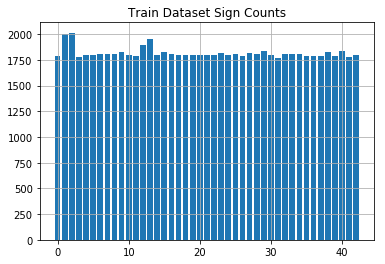

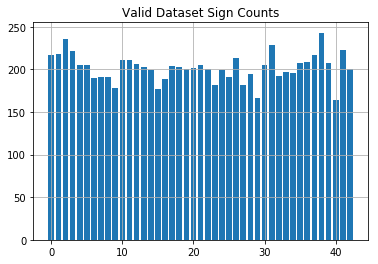

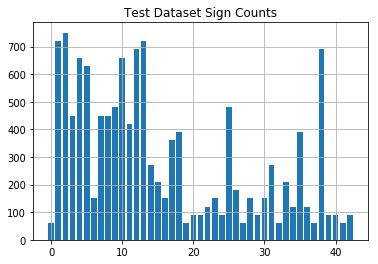

In [46]:
unique_train, counts_train = np.unique(y_train, return_counts=True)
plt.bar(unique_train, counts_train)
plt.grid()
plt.title("Train Dataset Sign Counts")
plt.show()

unique_valid, counts_valid = np.unique(y_valid, return_counts=True)
plt.bar(unique_valid, counts_valid)
plt.grid()
plt.title("Valid Dataset Sign Counts")
plt.show()

unique_test, counts_test = np.unique(y_test, return_counts=True)
plt.bar(unique_test, counts_test)
plt.grid()
plt.title("Test Dataset Sign Counts")
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [47]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.

In [48]:
#Convert to grayscale
X_train_gray = np.sum(X_train//3, axis=3, keepdims=True)
X_valid_gray = np.sum(X_valid//3, axis=3, keepdims=True)
X_test_gray = np.sum(X_test//3, axis=3,keepdims=True)

In [49]:
#Use grayscale from here on out
X_train = X_train_gray
X_valid = X_valid_gray
X_test = X_test_gray

In [50]:
# Normalize grayscale pixel data to range from -1.0 to 1.0
X_train = (X_train-128.0)/128.0
X_valid = (X_valid-128.0)/128.0
X_test = (X_test-128.0)/128.0

### Model Architecture

In [51]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
from sklearn.utils import shuffle
import tensorflow as tf

In [52]:
from tensorflow.contrib.layers import flatten
"""
# LeNet-5 Implementation from Class
def LeNet(x, keep_prob):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # TODO: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    F_W = tf.Variable(tf.truncated_normal([5, 5, 1, 6], mean=mu, stddev=sigma))
    F_b = tf.Variable(tf.zeros(6))
    x = tf.nn.conv2d(x, F_W, [1,1,1,1], padding='VALID') # fh = 5 size of weights = filter height
    x = tf.nn.bias_add(x, F_b)

    # TODO: Activation.
    x = tf.nn.relu(x)
    #x = tf.nn.dropout(x, keep_prob)

    # TODO: Pooling. Input = 28x28x6. Output = 14x14x6.
    x = tf.nn.max_pool(x, [1,2,2,1], [1,2,2,1], 'VALID')

    # TODO: Layer 2: Convolutional. Output = 10x10x16.
    F_W = tf.Variable(tf.truncated_normal([5, 5, 6, 16], mean=mu, stddev=sigma))
    F_b = tf.Variable(tf.zeros(16))
    x = tf.nn.conv2d(x, F_W, [1,1,1,1], padding='VALID') #fh = 5
    x = tf.nn.bias_add(x, F_b)
    
    # TODO: Activation.
    x = tf.nn.relu(x)
    #x = tf.nn.dropout(x, keep_prob)    

    # TODO: Pooling. Input = 10x10x16. Output = 5x5x16.
    x = tf.nn.max_pool(x, [1,2,2,1], [1,2,2,1], 'VALID')

    # TODO: Flatten. Input = 5x5x16. Output = 400.
    x = flatten(x)
    
    # TODO: Layer 3: Fully Connected. Input = 400. Output = 120.
    F_W = tf.Variable(tf.truncated_normal([400,120], mean=mu, stddev=sigma))
    F_b = tf.Variable(tf.zeros(120))
    x = tf.add(tf.matmul(x, F_W), F_b)
    
    # TODO: Activation.
    x = tf.nn.relu(x)
    #x = tf.nn.dropout(x, keep_prob)

    # TODO: Layer 4: Fully Connected. Input = 120. Output = 84.
    F_W = tf.Variable(tf.truncated_normal([120,84], mean=mu, stddev=sigma))
    F_b = tf.Variable(tf.zeros(84))
    x = tf.add(tf.matmul(x, F_W), F_b)
    
    # TODO: Activation.
    x = tf.nn.relu(x)
    #x = tf.nn.dropout(x, keep_prob)

    # TODO: Layer 5: Fully Connected. Input = 84. Output = 43.  # number of traffic sign classes
    F_W = tf.Variable(tf.truncated_normal([84,43], mean=mu, stddev=sigma))
    F_b = tf.Variable(tf.zeros(43))
    x = tf.add(tf.matmul(x, F_W), F_b)
    
    logits = x
    
    return logits
"""

"\n# LeNet-5 Implementation from Class\ndef LeNet(x, keep_prob):    \n    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer\n    mu = 0\n    sigma = 0.1\n    \n    # TODO: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.\n    F_W = tf.Variable(tf.truncated_normal([5, 5, 1, 6], mean=mu, stddev=sigma))\n    F_b = tf.Variable(tf.zeros(6))\n    x = tf.nn.conv2d(x, F_W, [1,1,1,1], padding='VALID') # fh = 5 size of weights = filter height\n    x = tf.nn.bias_add(x, F_b)\n\n    # TODO: Activation.\n    x = tf.nn.relu(x)\n    #x = tf.nn.dropout(x, keep_prob)\n\n    # TODO: Pooling. Input = 28x28x6. Output = 14x14x6.\n    x = tf.nn.max_pool(x, [1,2,2,1], [1,2,2,1], 'VALID')\n\n    # TODO: Layer 2: Convolutional. Output = 10x10x16.\n    F_W = tf.Variable(tf.truncated_normal([5, 5, 6, 16], mean=mu, stddev=sigma))\n    F_b = tf.Variable(tf.zeros(16))\n    x = tf.nn.conv2d(x, F_W, [1,1,1,1], padding='VALID') #fh = 5\n    x = tf.

In [53]:
# Modified LeNet inspired by LeCun's paper (Used for submission)
# * Adds an additional convolutional layer
# * The fully connected layer takes input from both layer2 and layer3
# * Leverages dropout

def LeNet2(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    F_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    F_b = tf.Variable(tf.zeros(6))
    x = tf.nn.conv2d(x, F_W, strides=[1, 1, 1, 1], padding='VALID')
    x = tf.nn.bias_add(x, F_b)

    # Activation.
    x = tf.nn.relu(x)
    
    # Pooling. Input = 28x28x6. Output = 14x14x6.
    x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # Layer 2: Convolutional. Output = 10x10x16.
    F_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    F_b = tf.Variable(tf.zeros(16))
    x = tf.nn.conv2d(x, F_W, strides=[1, 1, 1, 1], padding='VALID')
    x = tf.nn.bias_add(x, F_b)
                     
    # Activation.
    x = tf.nn.relu(x)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    layer2 = x    
    
    # Layer 3: Convolutional. Output = 1x1x400.
    F_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 16, 400), mean = mu, stddev = sigma))
    F_b = tf.Variable(tf.zeros(400))
    x = tf.nn.conv2d(x, F_W, strides=[1, 1, 1, 1], padding='VALID')
    x = tf.nn.bias_add(x, F_b)
                     
    # Activation.
    x = tf.nn.relu(x)
    layer3 = x

    # Flatten. Input = 5x5x16. Output = 400.
    layer2_flat = flatten(layer2)
    
    # Flatten x. Input = 1x1x400. Output = 400.
    layer3_flat = flatten(layer3)
    
    # Concat layer2flat and x. Input = 400 + 400. Output = 800
    x = tf.concat([layer3_flat, layer2_flat], 1)
    
    # Dropout
    x = tf.nn.dropout(x, keep_prob)
    
    # Layer 4: Fully Connected. Input = 800. Output = 43.
    F_W = tf.Variable(tf.truncated_normal(shape=(800, 43), mean = mu, stddev = sigma))
    F_b = tf.Variable(tf.zeros(43))    
    x = tf.add(tf.matmul(x, F_W), F_b)
    
    logits = x
    
    return logits


In [54]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1), name='x')
y = tf.placeholder(tf.int32, (None), name='y')
one_hot_y = tf.one_hot(y, 43)

keep_prob = tf.placeholder(tf.float32, name='keep_prob') # probability to keep units

In [55]:
#rate = 0.001
rate = 0.0009

logits = LeNet2(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [56]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

In [57]:
EPOCHS = 50
BATCH_SIZE = 100

In [58]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [59]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    validation_accuracy_history = []
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:0.75})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        validation_accuracy_history.append(validation_accuracy)
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.946

EPOCH 2 ...
Validation Accuracy = 0.973

EPOCH 3 ...
Validation Accuracy = 0.983

EPOCH 4 ...
Validation Accuracy = 0.988

EPOCH 5 ...
Validation Accuracy = 0.987

EPOCH 6 ...
Validation Accuracy = 0.989

EPOCH 7 ...
Validation Accuracy = 0.991

EPOCH 8 ...
Validation Accuracy = 0.990

EPOCH 9 ...
Validation Accuracy = 0.992

EPOCH 10 ...
Validation Accuracy = 0.991

EPOCH 11 ...
Validation Accuracy = 0.994

EPOCH 12 ...
Validation Accuracy = 0.990

EPOCH 13 ...
Validation Accuracy = 0.994

EPOCH 14 ...
Validation Accuracy = 0.994

EPOCH 15 ...
Validation Accuracy = 0.993

EPOCH 16 ...
Validation Accuracy = 0.994

EPOCH 17 ...
Validation Accuracy = 0.993

EPOCH 18 ...
Validation Accuracy = 0.994

EPOCH 19 ...
Validation Accuracy = 0.994

EPOCH 20 ...
Validation Accuracy = 0.995

EPOCH 21 ...
Validation Accuracy = 0.993

EPOCH 22 ...
Validation Accuracy = 0.996

EPOCH 23 ...
Validation Accuracy = 0.994

EPOCH 24 ...
Validation Accura

## Analyze the validation accuracy across epochs

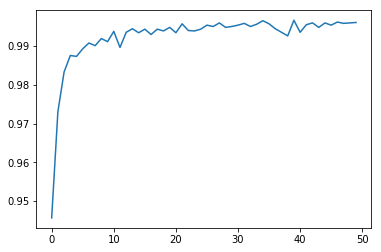

In [60]:
plt.plot(validation_accuracy_history)

In [61]:
with tf.Session() as sess:
    saver.restore(sess, './lenet')

    test_accuracy = evaluate(X_test_gray, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet
Test Accuracy = 0.940


## Look at some images that are not predicted correctly

In [62]:
failed = []
failed_class = []
with tf.Session() as sess:
    saver.restore(sess, './lenet')    
    for i in range(len(X_test)):
        activation = logits.eval(session=sess,feed_dict={x : [X_test[i]], keep_prob:1.0})
        if y_test[i] != np.argmax(activation):
            failed.append(i)
            failed_class.append(np.argmax(activation))

INFO:tensorflow:Restoring parameters from ./lenet


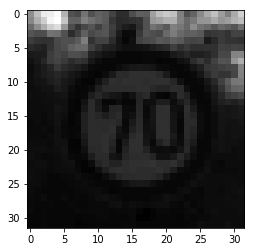

Actual Label: Speed limit (70km/h)
Mispredicted Label: Traffic signals


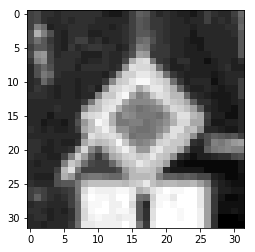

Actual Label: Priority road
Mispredicted Label: Traffic signals


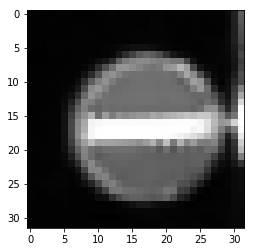

Actual Label: No entry
Mispredicted Label: Pedestrians


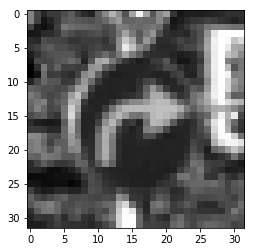

Actual Label: Turn right ahead
Mispredicted Label: Pedestrians


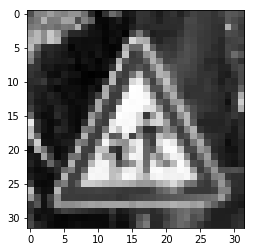

Actual Label: Children crossing
Mispredicted Label: Wild animals crossing


In [63]:
for j in range(5):
    i = random.randint(0,len(failed))
    plt.imshow((X_test[i].squeeze()+1.0)/2.0, cmap="gray")
    plt.show()
    print('Actual Label:', signnames[y_test[i]])
    print('Mispredicted Label:', signnames[failed_class[i]])

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [64]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Predict the Sign Type for Each Image

In [66]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

INFO:tensorflow:Restoring parameters from ./lenet


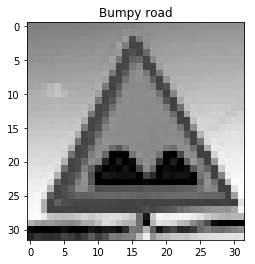

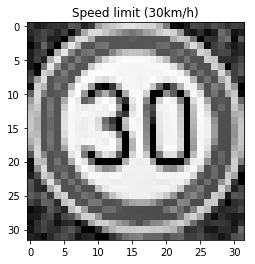

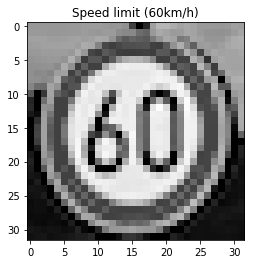

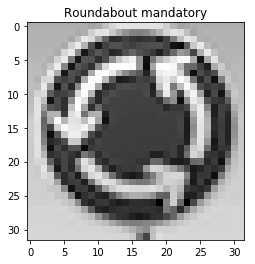

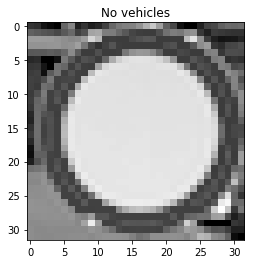

In [65]:
signs = ['bumpy.png','speed30.png','speed60.png','roundabout.png','restricted.png']
signs = list(map(lambda x: 'sample_images/'+x,signs))
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))    
    for s in signs:
        img = cv2.imread(s,cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = np.sum(img//3,axis=2,keepdims=True)
        plt.imshow(img.squeeze(),cmap="gray")
        activation = logits.eval(session=sess,feed_dict={x : np.array([img]), keep_prob:1.0})
        plt.title(signnames[np.argmax(activation)])
        plt.show()
    

### Analyze Performance
100% accuracy achieved on these images

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [68]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

In [69]:
signs = ['bumpy.png','speed30.png','speed60.png','roundabout.png','restricted.png']
signs = list(map(lambda x: 'sample_images/'+x,signs))
print(signs)
with tf.Session() as sess:
    #sess.run(tf.global_variables_initializer())
    #saver = tf.train.import_meta_graph('./lenet.meta')
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    softmax_logits = tf.nn.softmax(logits)
    top_k = tf.nn.top_k(softmax_logits, k=5)
    images = []
    for s in signs:    
        img = cv2.imread(s,cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB) 
        img = np.sum(img//3,axis=2,keepdims=True)
        images.append(img)
    
    my_softmax_logits = sess.run(softmax_logits, feed_dict={x: images, keep_prob: 1.0})
    my_top_k = sess.run(top_k, feed_dict={x: images, keep_prob: 1.0})

['sample_images/bumpy.png', 'sample_images/speed30.png', 'sample_images/speed60.png', 'sample_images/roundabout.png', 'sample_images/restricted.png']
INFO:tensorflow:Restoring parameters from ./lenet


In [70]:
my_top_k

TopKV2(values=array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   2.29365138e-11,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00]], dtype=float32), indices=array([[22,  0,  1,  2,  3],
       [ 1,  0,  2,  3,  4],
       [ 3,  5,  0,  1,  2],
       [40,  0,  1,  2,  3],
       [15,  0,  1,  2,  3]], dtype=int32))

In [71]:
signnames[3]

'Speed limit (60km/h)'

## Top 5 Softmax
One image was misclassified the "Speed limit (60km/h)" image at index 2.  If we look at the softmax predictions we don't get into the correct prediction until the 4th prediction.  One interesting thing is that the probabilites are all either 0.0 or 1.0.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

### Daily Log
02/17/2020: finished up with validation 0.89 and test 0.757 - changed from rgb to grayscale

02/19/2020: created new image samples (no mods) validation 9.11 but test dropped to 0.697

02/19/2020: new image samples with random scale and rotate (same validation though) 0.916; test 0.748

02/19/2020: 0.979 validation accuracy... by joining train, valid, test and resplitting with new image samples (no test)

02/19/2020: 0.993 validation accuracy; 0.851 test with 100 epochs

02/20/2020: 0.992 validation accuracy; 0.857 test with 20 epochs

02/20/2020: 0.996 validation accuracy: 0.810 test with 100 epochs

02/21/2020: final run; 50 epochs; 0.996 validation accuracy; 0.940 test accuracy

